In [1]:
import os
import math
import numpy as np
import torch
import train_vit as train_vit
import train_spectra as train_spectra
import matplotlib.pyplot as plt
import test as te
import data.prepare_sers_data as psd 
import imp
import utils
import vis_utils as vu
import models.spectra_model as spectra_model
import configs.common as common
import time 

def get_freer_gpu():
    os.system('nvidia-smi -q -d Memory |grep -A4 GPU|grep Free >tmp')
    memory_available = [int(x.split()[2]) for x in open('tmp', 'r').readlines()]
    return np.argsort(memory_available)

num_gpu = 1
free_id = get_freer_gpu()
device = torch.device("cuda") if len(free_id) > 0 else torch.device("cpu")

if len(free_id) > 0:
    use_id = free_id[-num_gpu:]
    use_id_list = ",".join(["%d" % i for i in use_id])
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = use_id_list


sh: nvidia-smi: command not found
sh: nvidia-smi: command not found


## User-define
- define the dataset 
- define detection and quantification (if detection is True, then quantification has to be False)
- define the directory that saves the dataset

In [17]:
dataset = "DNP"
detection = False
quantification = True
leave_index=0 

const = common.get_config_test_vit(dataset, detection, quantification, leave_index=leave_index)
path_mom="datasets/"  # USER DEFINE


## Load the dataset

In [11]:
print(dataset)
imp.reload(psd)
data_obj = psd.ReadSERSData(dataset, target_shape=const.target_shape, 
                            percentage=0, top_selection_method="sers_maps", 
                            path_mom=path_mom, quantification=quantification,
                            detection=detection,
                            leave_index=const.leave_index, 
                            leave_method=const.leave_method)

DNP


In [12]:
[tr_maps, tr_label, tr_conc, tr_peak, tr_wave], [val_maps, val_label, val_conc, val_peak], \
    [tt_maps, tt_label, tt_conc, tt_peak, tt_wave], imshape, num_class = data_obj.forward_test()

**************I will only leave one measurement out************
Training chip index: (array([1, 2, 3, 4, 5]), array([4, 5, 5, 5, 5]))
Testing chip index: (array([1]), array([1]))
There are 19 training data and 5 validation data
The replicated validation index in the training []
----------------------Before augmenting the data----------------------
SERS map shape (19, 44, 44, 389)
Unique label and count (array([1.]), array([19]))
Unique concentration and count (array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]), array([3, 4, 4, 4, 4]))
                                                                       
----------------------Before augmenting the data----------------------
SERS map shape (5, 44, 44, 389)
Unique label and count (array([1.]), array([5]))
Unique concentration and count (array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]), array([1, 1, 1, 1, 1]))
                                                                       
=============================================Training========

## Load the models 
We repeat each experiment five times to calculate the ensemble prediction

In [13]:
imp.reload(te)
exp_dir = "exp_data/VIT/"
ckpt_group = te.get_ckpt(dataset, detection, quantification, const, exp_dir=exp_dir)

There are 3 models for ensemble calculation


sh: nvidia-smi: command not found


In [18]:
model_use = train_vit.ViTLightning(num_class, tuple([const.patch_size,const.patch_size]), 
                                   const.input_feature, const.num_layers, const.num_heads, 
                                   const.mlp_dim, 0, 2, 10, 10, num_gpu, 0.03, add_positional_encoding=True, 
                                   quantification=quantification, detection=detection, imshape=imshape,
                                   concentration_float=const.concentration_float)    

44 44 2 2
Patch height 2 Patch width 2 Image shape 44 44


## Run detection/quantification and give the ensemble predictions

In [19]:
imp.reload(te)
prediction_group = []
wavecut = np.arange(np.shape(tt_maps)[-1])
time_g = 0.0
for s_ckpt in ckpt_group:
    model_update = model_use.load_from_checkpoint(s_ckpt)
    model_update.eval()
    model_update.requires_grad_(False)
    model_update.to(device)
    test_obj = te.Test(tt_maps, tt_label, tt_conc, tt_peak, model_update,
                    [const.patch_size, const.patch_size], imshape[:-1],
                    tds_dir=None, save=False)
    time_init = time.time()
    pred, quan, rsquare = test_obj.get_vit_accuracy()
    time_g += (time.time() - time_init)
    if detection:
        prediction_group.append(pred)
    else:
        prediction_group.append(quan)
print("Inference time for one SERS map", time_g / len(ckpt_group))    

sh: nvidia-smi: command not found
/Users/blia/Documents/experiments/molecule_detection_quantification_vit/utils.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  r_square = 1.0 - top / bottom


44 44 2 2
Patch height 2 Patch width 2 Image shape 44 44
The concentration float  1e-06
44 44 2 2
Patch height 2 Patch width 2 Image shape 44 44
The concentration float  1e-06
44 44 2 2
Patch height 2 Patch width 2 Image shape 44 44
The concentration float  1e-06
Inference time for one SERS map 0.042012691497802734


In [20]:
avg_pred = np.mean(prediction_group, axis=0)
if dataset == "TOMAS" or dataset == "DNP":
    if detection:
        print("True class:", tt_label, " Predicted class:", np.argmax(avg_pred, axis=-1))
    else:
        if len(tt_conc) == 1:
            print("True concentration: %.4f (1e-6)" % tt_conc, " Predicted concentration", quan[0])
        else:
            for v, q in zip(tt_conc, avg_pred):
                print("GT concentration: %.5f vs predicted concentration: %.5f" % (v, q))
        print("rsquare:", utils.calc_rsquare(tt_conc, avg_pred))
        print("rsquare(log-transform):", utils.calc_rsquare(np.log(tt_conc), np.log(avg_pred)))
else:
    if detection:
        print("Global accuracy", utils.calc_global_accuracy(avg_pred, tt_label))
    else:
        print("Rsquare of log transformed concentration", utils.get_quantification_performance(tt_conc, 
                                                                                               quan, 
                                                                                               print_info=True))

True concentration: 0.0001 (1e-6)  Predicted concentration 0.00053666724
rsquare: -inf
rsquare(log-transform): -inf


SERS map: concentration: 0.0001


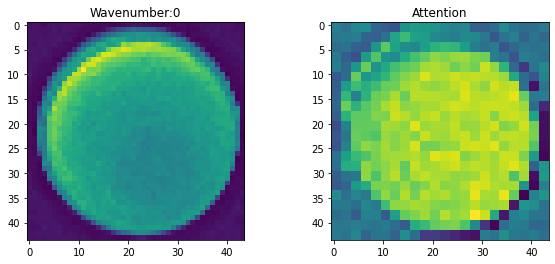

In [22]:
start=0
print("SERS map: concentration: %.4f" % tr_conc[start])
_out = test_obj._get_single_attention_map(tr_maps[start:start+1])
p_use = np.where(tr_wave >= tr_peak[0])[0][0]
s_attn_map, s_attn_imsize = test_obj._reorganize_attention_map_to_image(_out[1], _out[0], [p_use],
                                                                        show=True, save=False)